# Lower Star Image Filtration
In this notebook, I have implemented lower star filtration, or sublevelset filtration, on image data. This filtration will allow us to express local minimums (or maximums if flipped) as birth times and saddle points as death times in a 0-dimensional persistence diagram. This is a useful and provably stable way of summarizing critical points in an image.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import ndimage
import PIL

from persim import plot_diagrams
from ripser import ripser, lower_star_img

import pandas as pd
from scipy import sparse
import time

from ripser import ripser
from persim import plot_diagrams


from sklearn import datasets
from sklearn.metrics.pairwise import pairwise_distances

import tadasets


we've created a function that constructs a 0-dimensional lower star filtration from an image. In this setup, each pixel in the image acts as a vertex, and we connect each vertex to its 8 spatial neighbors. However, if a pixel is at the image's edge, it might have fewer neighbors due to the boundary.

The connections between these vertices are assigned weights based on the maximum pixel value they connect, hence the term "lower star." Even though we're dealing with a large number of pixels, this code runs quickly. It's nearly linear in terms of the number of pixels because there's a linear number of edges relative to the number of pixels, and we're computing only 0-dimensional homology.

# Test Example

Now, let's test out this code on an example with an image containing some Gaussian blobs. We will put three negative Gaussians in this image; one which reaches its local min at -3, one at -2, and one at -1:


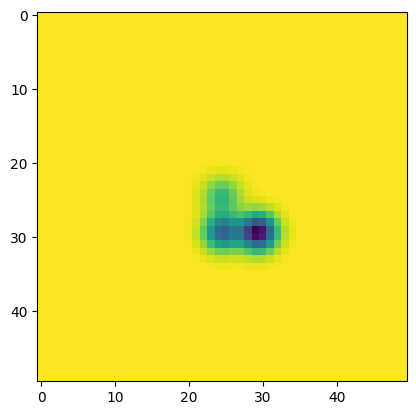

In [2]:
ts = np.linspace(-1, 1, 50)
x1 = np.exp(-ts**2/(0.1**2))
ts -= 0.2
x2 = np.exp(-ts**2/(0.1**2))
img = -x1[None, :]*x1[:, None] - 2*x1[None, :]*x2[:, None] - 3*x2[None, :]*x2[:, None]
plt.imshow(img)
plt.show()



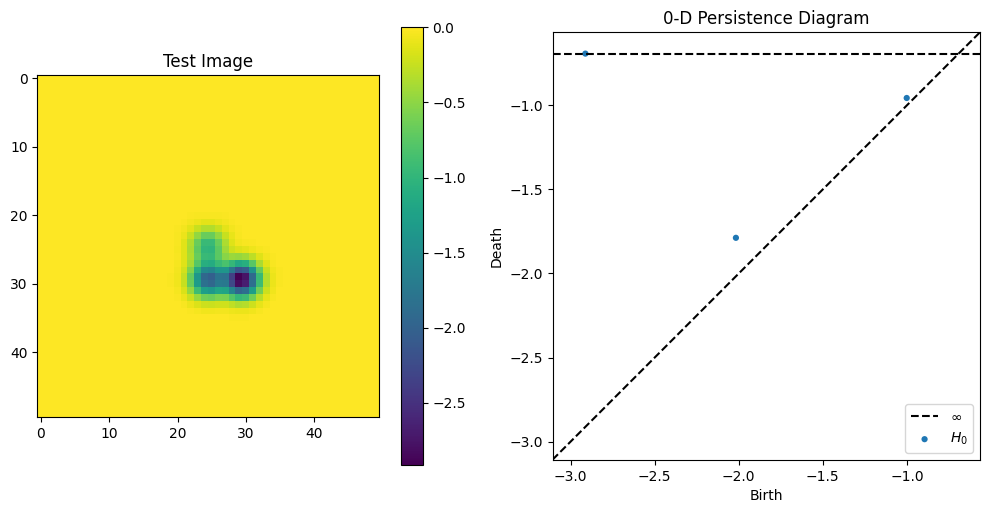

In [3]:
dgm = lower_star_img(img)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img)
plt.colorbar()
plt.title("Test Image")
plt.subplot(122)
plot_diagrams(dgm)
plt.title("0-D Persistence Diagram")
plt.tight_layout()
plt.show()


# C. Elegans Image Example

When we grayscale the image within the range [0 to 255], with 0 representing dark and 255 signifying bright, we observe that the insides of the cells appear bright, while each cell intersects at a low point near the boundary, which is closer to 0.

In this scenario, we suggest that there exists a local maximum with substantial persistence within each cell. This means we want to conduct an analysis where we focus on high points rather than low points, essentially performing a superlevelset or upper star filtration.

To adapt our code for this purpose, we can simply input the negative of the image into the lower star filtration function. Let's proceed with this adjustment and visualize the lifetimes accordingly.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


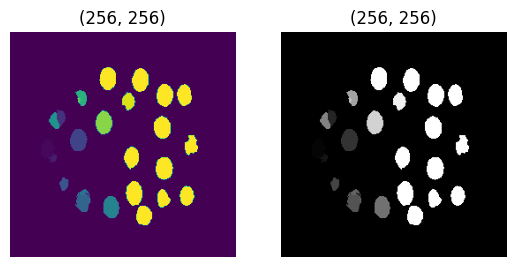

In [6]:
# cells_original = plt.imread("/home/hrc/gsoc/d-gnn/training_data_pil/images/real_8_37.png")
cells_original = plt.imread("/home/hrc/Downloads/GSoC/dataset/segmentation_maps_1/L72_16.png")

print(cells_original)
# cells_grey = np.asarray(PIL.Image.fromarray(cells_original).convert('L'))
# print(cells_grey)

plt.subplot(121)
plt.title(cells_original.shape)
plt.imshow(cells_original)
plt.axis('off')
plt.subplot(122)
plt.title(cells_original.shape)
plt.imshow(cells_original, cmap='gray')
plt.axis('off')
plt.show()

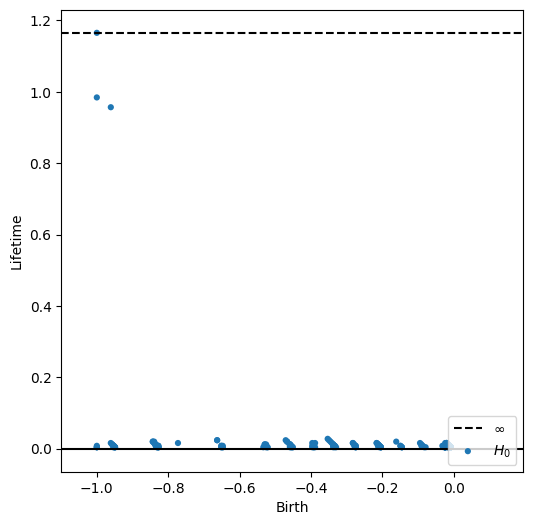

In [7]:
dgm = lower_star_img(-cells_original)

plt.figure(figsize=(6, 6))
plot_diagrams(dgm, lifetime=True)
plt.show()

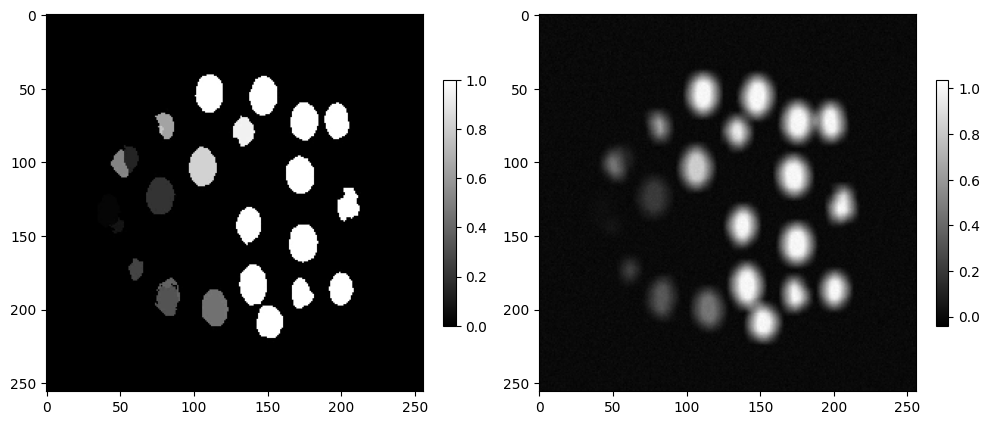

In [8]:
smoothed = ndimage.uniform_filter(cells_original.astype(np.float64), size=10)
smoothed += 0.01 * np.random.randn(*smoothed.shape)

plt.figure(figsize=(10, 5))
plt.subplot(121)
im = plt.imshow(cells_original, cmap='gray')
plt.colorbar(im, fraction=0.03)

plt.subplot(122)
im = plt.imshow(smoothed, cmap='gray')
plt.colorbar(im, fraction=0.03)

plt.tight_layout()
plt.show()


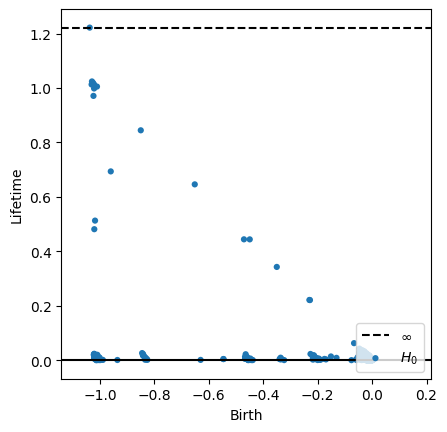

In [9]:
dgm = lower_star_img(-smoothed)
plot_diagrams(dgm, lifetime=True)
plt.show()


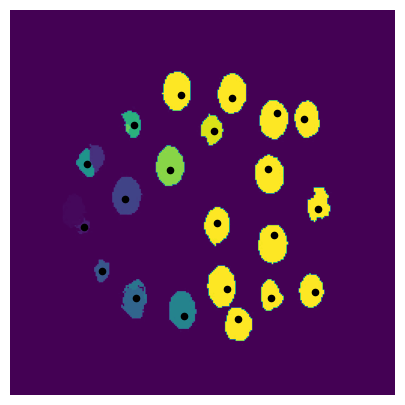

In [10]:
thresh = 0.05
idxs = np.arange(dgm.shape[0])
idxs = idxs[np.abs(dgm[:, 1] - dgm[:, 0]) > thresh]

plt.figure(figsize=(8, 5))
plt.imshow(cells_original)

X, Y = np.meshgrid(np.arange(smoothed.shape[1]), np.arange(smoothed.shape[0]))
X = X.flatten()
Y = Y.flatten()
for idx in idxs:
    bidx = np.argmin(np.abs(smoothed + dgm[idx, 0]))
    plt.scatter(X[bidx], Y[bidx], 20, 'k')
plt.axis('off')

plt.show()

# Visualizing the Raw data of points and performing basic tasks

In [11]:
from mpl_toolkits.mplot3d import Axes3D

In [12]:
data = pd.read_csv('DevoGraph/data/CE_raw_data.csv')
df = data
# after 190 time sets to 167

In [13]:
data[:50]

,Unnamed: 0,cell,time,x,y,z,size
0,0,AB,1,454.0,286.0,14.0,53.0
1,1,AB,2,494.0,244.0,14.5,68.0
2,2,AB,3,497.0,235.0,14.0,48.0
3,3,AB,4,491.0,223.0,14.0,50.0
4,4,ABa,5,519.0,272.0,14.3,70.0
5,5,ABa,6,521.0,259.0,14.9,71.0
6,6,ABa,7,553.0,255.0,14.5,75.0
7,7,ABa,8,572.0,248.0,14.5,79.0
8,8,ABa,9,578.0,261.0,14.7,82.0
9,9,ABa,10,581.0,268.0,16.2,86.0


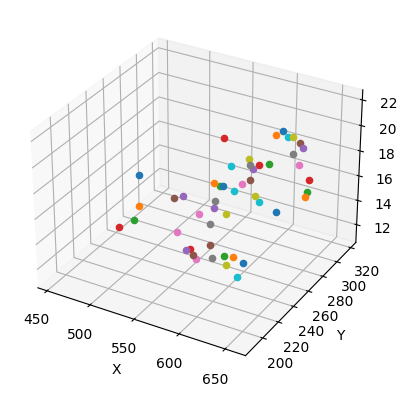

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for t in range(50):
    x = data['x'].iloc[t]
    y = data['y'].iloc[t]
    z = data['z'].iloc[t]
    ax.scatter(x, y, z, label=f'Timestamp {t + 1}')
# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add a legend
# ax.legend()

# Show the plot
plt.show()



# Code to convert 3d data to 2d to plot persistence diagram

In [15]:
import numpy as np 
import cv2 
  
# Define the camera matrix 
fx = 800
fy = 800
cx = 640
cy = 480
camera_matrix = np.array([[fx, 0, cx], 
                          [0, fy, cy], 
                          [0, 0, 1]], np.float32) 
  
# Define the distortion coefficients 
dist_coeffs = np.zeros((5, 1), np.float32) 

points_list = []
  
# Define the 3D point in the world coordinate system 
for t in range(50):
    x = data['x'].iloc[t]
    y = data['y'].iloc[t]
    z = data['z'].iloc[t]
    # x, y, z = 10, 20, 30
    points_3d = np.array([[[x, y, z]]], np.float32) 

    # Define the rotation and translation vectors 
    rvec = np.zeros((3, 1), np.float32) 
    tvec = np.zeros((3, 1), np.float32) 

    # Map the 3D point to 2D point 
    points_2d, _ = cv2.projectPoints(points_3d, 
                                     rvec, tvec, 
                                     camera_matrix, 
                                     dist_coeffs) 
    points_2d = points_2d.reshape(1,2)
    point = points_2d[0]
    points_list.append(point)
  
# Display the 2D point 
print("2D Point:", points_list) 


2D Point: [array([26582.857, 16822.857], dtype=float32), array([27895.172, 13942.069], dtype=float32), array([29040.   , 13908.571], dtype=float32), array([28697.143, 13222.857], dtype=float32), array([29674.965, 15696.783], dtype=float32), array([28613.154, 14386.041], dtype=float32), array([31150.346, 14548.966], dtype=float32), array([32198.621, 14162.759], dtype=float32), array([32095.783, 14684.082], dtype=float32), array([29331.357, 13714.567], dtype=float32), array([29357.947, 14736.41 ], dtype=float32), array([28742.562, 14787.692], dtype=float32), array([31062.535, 17156.057], dtype=float32), array([25789.7  , 15713.532], dtype=float32), array([36846.895, 21514.482], dtype=float32), array([39387.824, 18914.783], dtype=float32), array([39727.72 , 17813.334], dtype=float32), array([40361.74, 17940.87], dtype=float32), array([41118.633, 17300.514], dtype=float32), array([43684.246, 17612.742], dtype=float32), array([39872., 16032.], dtype=float32), array([36788.15 , 14346.667], d

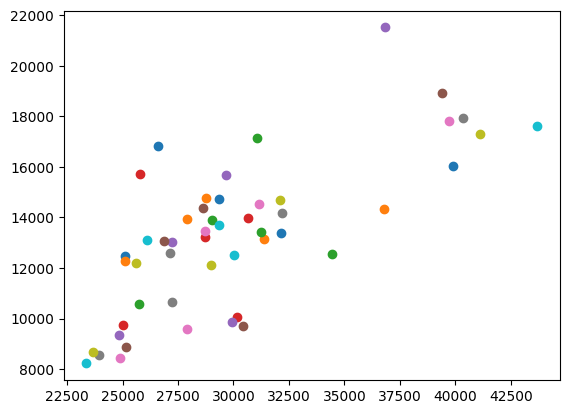

In [16]:
fig = plt.figure()
# ax = fig.add_subplot(11, projection='2d')
for t in range(50):
    x = points_list[t][0]
    y = points_list[t][1]
    plt.scatter(x, y, label=f'Timestamp {t + 1}')
# Set labels for the axes
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# Add a legend
# ax.legend()

# Show the plot
plt.show()

In [17]:
from ripser import ripser
from persim import plot_diagrams

In [18]:
points_list = np.array(points_list)

In [19]:
data = datasets.make_circles(n_samples=100)[0] + 5 * datasets.make_circles(n_samples=100)[0]

# print(data)

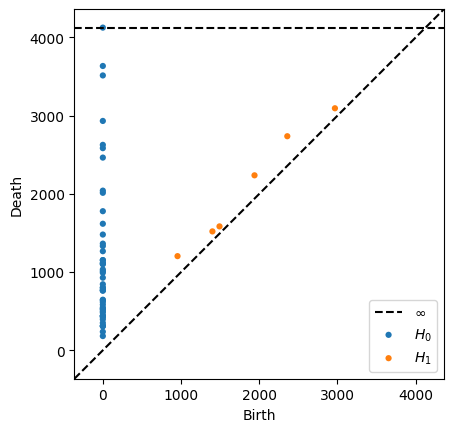

In [20]:
dgms = ripser(points_list)['dgms']
plot_diagrams(dgms, show=True)